In [1]:
# run stopwatch
from tools import Stopwatch
stopwatch = Stopwatch()
start = stopwatch.start()

### Load libraries, functions, palette, theme

In [2]:
%run _libraries.ipynb

In [3]:
%run _functions.ipynb

In [4]:
dir_current = '03-arima-month'

In [5]:
dir_save_files = 'files/'

In [6]:
dir_load_files = 'files/'

In [7]:
dir_save_img = 'docs/img/'

In [8]:
session_name = dir_current

# Section III. ARIMA

## Load Saved Section if exists

## Load Data

In [9]:
train = loadit('train_preprocessed', dir=dir_load_files)

In [10]:
valid = loadit('valid_preprocessed', dir=dir_load_files)

In [11]:
test = loadit('test_preprocessed', dir=dir_load_files)

## Stationarity

p< 0.05: Enough evidence to say, that process is stationarity

In [12]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train['target1'])

(-28.686047970170506,
 0.0,
 47,
 30480,
 {'1%': -3.4305645620343594,
  '5%': -2.8616348306743395,
  '10%': -2.566820475464527},
 460471.5647015386)

In [13]:
train['month'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [14]:
for i in train['month'].unique():
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, 'target1'])[1])
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, 'target1'])[1] < 0.05)

1.0644033759839667e-22
True
3.732657699349194e-20
True
7.432116387741869e-24
True
1.7428395333340719e-23
True
2.955844723407367e-22
True
4.44900636796093e-19
True
8.442519583711138e-20
True


In [15]:
for i in train['month'].unique():
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, 'target1'].diff()[1:])[1])
    print(sm.tsa.stattools.adfuller(train.loc[train['month']==i, 'target1'].diff()[1:])[1] < 0.05)

4.97351764764749e-26
True
4.483001520404638e-24
True
6.141089115772981e-28
True
3.702018465634753e-28
True
1.1368337132320429e-27
True
5.506358370607743e-23
True
1.2150033480795901e-26
True


## Autocorrelation

#### ACF - 40 period

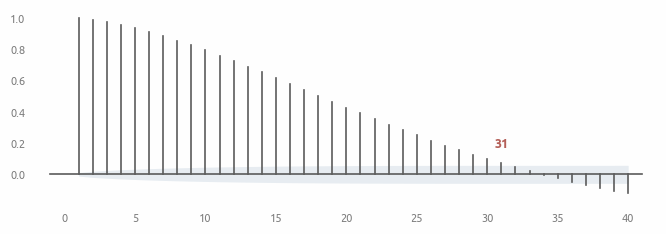

In [16]:
fig = plt.figure()
plot_acf(data=train['target1'], lags=40)

In [17]:
ts_acf_last_significant_index(train['target1'])

31

#### ACF - 300 period

Images 'ACF_300.png' and 'ACF_300.svg' successfully saved into 'docs/img/' directory


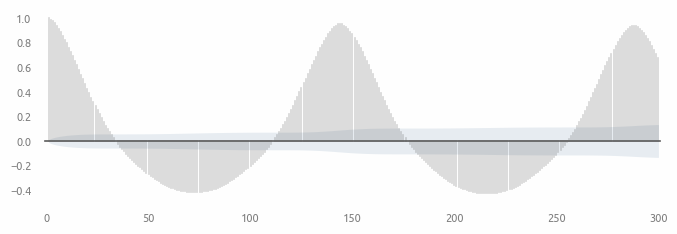

In [18]:
fig = plt.figure()
plot_acf(data=train['target1'], lags=300, transparency_lines=0.25, show_last_significant=False)
savefig('ACF_300', dir_save_img)

#### PACF - 40 period

In [19]:
pacf = ts_acf_calculate(train['target1'], lags=36, partial=True)

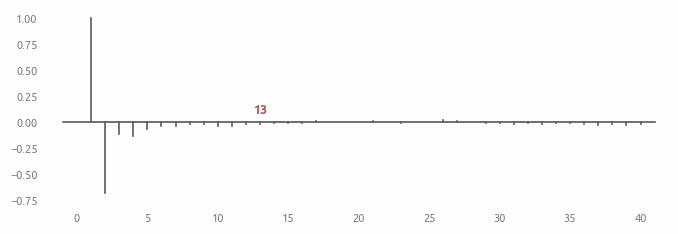

In [20]:
fig = plt.figure()

plot_acf(data=train['target1'], partial=True)

In [21]:
ts_acf_last_significant_index(data=train['target1'], partial=True)

13

## Model №1: ARIMA without seasonality and exogs

### Datasets

Train: July data;  
Validation: August data.

In [22]:
y = train.loc['2017-07-01':, 'target1'].copy()

In [23]:
y

2017-07-01 00:00:00    36384.31894
2017-07-01 00:10:00    35689.03654
2017-07-01 00:20:00    34751.36213
2017-07-01 00:30:00    33954.01993
2017-07-01 00:40:00    33411.82724
                          ...     
2017-07-31 23:10:00    43407.30897
2017-07-31 23:20:00    42507.90698
2017-07-31 23:30:00    41659.53488
2017-07-31 23:40:00    40843.05648
2017-07-31 23:50:00    39631.09635
Freq: 10min, Name: target1, Length: 4464, dtype: float64

In [24]:
y_true = valid['target1'].copy()

In [25]:
y_true

2017-08-01 00:00:00    38517.20311
2017-08-01 00:10:00    37973.80688
2017-08-01 00:20:00    37308.94562
2017-08-01 00:30:00    36164.61709
2017-08-01 00:40:00    35678.75694
                          ...     
2017-08-31 23:10:00    38619.48946
2017-08-31 23:20:00    38370.16648
2017-08-31 23:30:00    37724.48391
2017-08-31 23:40:00    36874.22863
2017-08-31 23:50:00    36215.76027
Freq: 10min, Name: target1, Length: 4464, dtype: float64

### ACF and PACF for differenced data

Images 'ACF_diff.png' and 'ACF_diff.svg' successfully saved into 'docs/img/' directory


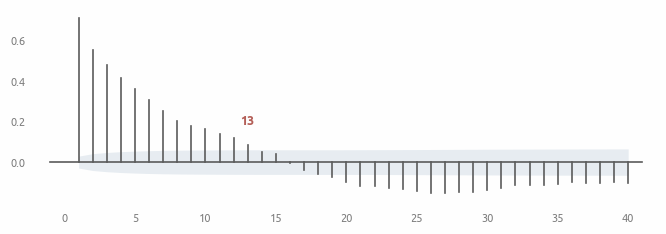

In [26]:
fig = plt.figure()

plot_acf(data=y.diff(1)[1:])
savefig('ACF_diff', dir_save_img)

Images 'PACF_diff.png' and 'PACF_diff.svg' successfully saved into 'docs/img/' directory


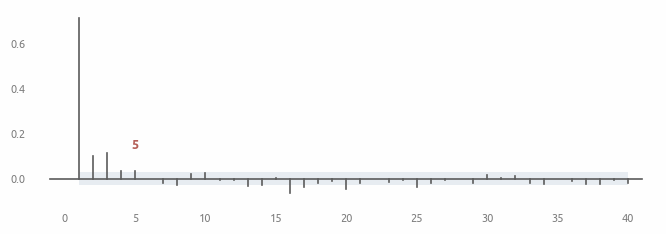

In [27]:
fig = plt.figure()

plot_acf(data=y.diff(1)[1:], partial=True)
savefig('PACF_diff', dir_save_img)

### Model selection

#### Manual model selection

In [28]:
arima511 = SARIMAX(
    y, exog=None,
    order=(3,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [29]:
print(arima511.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -33786.005
Date:                Thu, 18 Apr 2024   AIC                          67582.010
Time:                        10:45:36   BIC                          67614.028
Sample:                    07-01-2017   HQIC                         67593.296
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9631      0.107      9.015      0.000       0.754       1.173
ar.L2         -0.2024      0.064     -3.180      0.001      -0.327      -0.078
ar.L3          0.0751      0.017      4.526      0.0

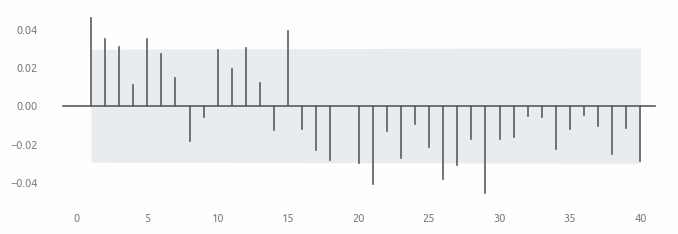

In [30]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=arima511.resid[1:])

In [31]:
arima411 = SARIMAX(
    y, exog=None,
    order=(4,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [32]:
arima411.aic < arima511.aic

False

In [33]:
arima411.aic

67583.9319638164

In [34]:
arima511.aic

67582.0097609724

In [35]:
arima311 = SARIMAX(
    y, exog=None,
    order=(5,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [36]:
arima511.aic < arima311.aic

True

In [37]:
arima412 = SARIMAX(
    y, exog=None,
    order=(4,1,2),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [38]:
arima412.aic < arima511.aic

True

In [39]:
arima412.aic

67470.5863748277

In [40]:
arima413 = SARIMAX(
    y, exog=None,
    order=(4,1,3),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [41]:
arima413.aic < arima412.aic

False

In [42]:
arima414 = SARIMAX(
    y, exog=None,
    order=(4,1,4),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [43]:
arima414.aic < arima412.aic

False

In [44]:
arima612 = SARIMAX(
    y, exog=None,
    order=(6,1,2),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [45]:
arima612.aic < arima412.aic

False

In [46]:
arima613 = SARIMAX(
    y, exog=None,
    order=(6,1,3),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/achasovsky/Data Science Environments/electric-power-consumption/electric-power-consumption/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [47]:
arima613.aic < arima412.aic

False

In [48]:
print(arima412.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -33728.293
Date:                Thu, 18 Apr 2024   AIC                          67470.586
Time:                        10:46:09   BIC                          67515.411
Sample:                    07-01-2017   HQIC                         67486.388
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2786      0.053     42.640      0.000       2.174       2.383
ar.L2         -1.6635      0.084    -19.903      0.000      -1.827      -1.500
ar.L3          0.4148      0.031     13.597      0.0

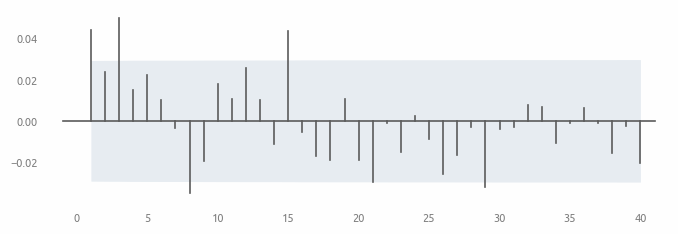

In [49]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=arima412.resid[1:])

#### Automatic model selection

In [50]:
%%time
model_auto = auto_arima(y)

CPU times: user 51.8 s, sys: 6.1 s, total: 57.9 s
Wall time: 33.1 s


In [51]:
model_auto

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [52]:
arima_auto = SARIMAX(
    y, exog=None,
    order=(1,1,2),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [53]:
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4464
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -33786.090
Date:                Thu, 18 Apr 2024   AIC                          67580.181
Time:                        10:46:44   BIC                          67605.795
Sample:                    07-01-2017   HQIC                         67589.210
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8373      0.010     82.181      0.000       0.817       0.857
ma.L1         -0.2494      0.013    -19.557      0.000      -0.274      -0.224
ma.L2         -0.1273      0.014     -9.032      0.0

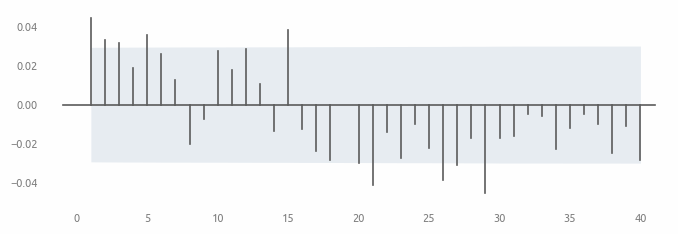

In [54]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=model_auto.resid()[1:])

In [55]:
test_LLR(arima_auto, arima412, df=2-1)

p-value: 0.0


In [56]:
arima_auto.aic < arima412.aic

False

In [57]:
arima_auto.aic

67580.18091941482

##### LLR Test

In [58]:
test_LLR(arima_auto, arima412, 3)

p-value: 0.0


#### Final ARIMA

In [59]:
arima = arima412

In [60]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -33728.293
Date:                Thu, 18 Apr 2024   AIC                          67470.586
Time:                        10:46:45   BIC                          67515.411
Sample:                    07-01-2017   HQIC                         67486.388
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2786      0.053     42.640      0.000       2.174       2.383
ar.L2         -1.6635      0.084    -19.903      0.000      -1.827      -1.500
ar.L3          0.4148      0.031     13.597      0.0

#### Forecast

In [61]:
len(y_true)

4464

In [62]:
arima_f = ts_arima_forecast(arima, steps=4464, data=y.to_frame(), ci=[80, 95])

In [63]:
arima_f

,data,is_forecast,lower_ci80,upper_ci80,lower_ci95,upper_ci95
2017-07-01 00:00:00,36384.318940,0,NaN,NaN,NaN,NaN
2017-07-01 00:10:00,35689.036540,0,NaN,NaN,NaN,NaN
2017-07-01 00:20:00,34751.362130,0,NaN,NaN,NaN,NaN
2017-07-01 00:30:00,33954.019930,0,NaN,NaN,NaN,NaN
2017-07-01 00:40:00,33411.827240,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-08-31 23:10:00,35802.234822,1,27839.359167,43765.110476,23624.067422,47980.402221
2017-08-31 23:20:00,35802.234822,1,27839.356669,43765.112975,23624.063601,47980.406042
2017-08-31 23:30:00,35802.234822,1,27839.354171,43765.115473,23624.059780,47980.409863
2017-08-31 23:40:00,35802.234822,1,27839.351672,43765.117971,23624.055960,47980.413684


In [ ]:
plt.figure(figsize=(9, 3))
ts_plot_arima_forecast(arima_f.iloc[-4464:, :])
plt.plot(y_true, color=saturate_color(palette[0], 1))
axis_rstyle()
plt.show()

savefig('auto_arima', dir_save_img)

In [ ]:
arima_forecast = arima_f.loc[arima_f['is_forecast']==1, 'data']

##### MAE

In [ ]:
mean_absolute_error(arima_forecast, y_true)

##### MAPE

In [ ]:
mean_absolute_percentage_error(arima_forecast, y_true) * 100

##### RMSE

In [ ]:
root_mean_squared_error(arima_forecast, y_true)

## Model №2: ARIMA with seasonality

### Fourier transform

In [ ]:
y_values = y.values

In [ ]:
y_values_trend = scipy.signal.savgol_filter(y_values, 25, 1)

In [ ]:
y_values_detrended = y_values - y_values_trend

In [ ]:
fft_x = np.fft.fftfreq(len(y_values_detrended))
fft_x = fft_x[:len(fft_x)//2]

In [ ]:
fft_y = np.fft.fft(y_values_detrended)
fft_y = np.abs(fft_y[:len(fft_y)//2])

In [ ]:
fft_y_peaks_indices = get_peaks_indicies(fft_y, boundary=500000)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

plt.subplot(2, 1, 1)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_)}'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Periods')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplot(2, 1, 2)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_/6)} h'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Hours')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('fourier_transform', dir_save_img)

In [ ]:
arima_fourier_periods = [144, 72, 48, 36]

### Model and Fourier order selection with CV

In [ ]:
train_start = dt.datetime(2017,2,1)
back_start = dt.datetime(2017,2,1)
forward_finish = dt.datetime(2017,9,30)
lw=15

fig = plt.figure(figsize=(8, 3))
ax=ax_current()

for i in arange(7):
    back_finish = train_start - dt.timedelta(days=1)
    ev_start = dt.datetime(2017, train_start.month+1, 1)
    forward_start = dt.datetime(2017, train_start.month+2, 1)
    train_finish = \
        dt.datetime(2017, train_start.month+1, 1) - dt.timedelta(days=1)
    ev_finish = \
        dt.datetime(2017, train_start.month+2, 1) - dt.timedelta(days=1)
    
    range_back = pd.date_range(back_start, back_finish, freq='d')
    range_train = pd.date_range(train_start, train_finish, freq='d')
    range_ev = pd.date_range(ev_start, ev_finish, freq='d')
    range_forward = pd.date_range(forward_start, forward_finish, freq='d')

    len_train = (train_finish - train_start).days
    len_ev = (ev_finish - ev_start).days

    color_back = color_forward = alpha_color(palette[-1], 0.4)
    color_ev = alpha_color(palette[2], 1)
    
    if i == 5:
        color_ev = palette[3]
    if i == 6:
        color_ev = palette[1]

    ax.plot(
        range_back,
        [7-i]*len(range_back),
        lw=lw,
        solid_capstyle='butt',
        color=color_back)

    ax.plot(
        range_train,
        [7-i]*len(range_train),
        lw=lw,
        solid_capstyle='butt',
        color=palette[0])

    ax.plot(
        range_ev,
        [7-i]*len(range_ev),
        lw=lw,
        solid_capstyle='butt',
        color=color_ev)

    ax.plot(
        range_forward,
        [7-i]*len(range_forward),
        lw=lw,
        solid_capstyle='butt',
        color=color_forward)
    
    ax.annotate(
        train_start.strftime("%B")[:3],
        xy=(dt.datetime(2017, train_start.month,
                        int(round(len_train/2))+1), 7-i-0.1),
        ha='center',
        color='white',
        weight='bold',
        size=8)

    ax.annotate(
        ev_start.strftime("%B")[:3],
        xy=(dt.datetime(2017, ev_start.month,
                        int(round(len_ev/2))+1), 7-i-0.1),
        ha='center',
        color='white',
        weight='bold',
        size=8)
    
    train_start = dt.datetime(2017, train_start.month+1, 1)

ax.legend(
    **legend_create_handles(
        n=4, kind='rect',
        labels=['Train', 'Evaluation', 'Validation', 'Test'],
        colors=[palette[0], alpha_color(palette[2], 1),
                palette[3], palette[1]], alpha=1),
    **legend_inline())

axis_rstyle(
    y_axis_hide=True, x_ticks_hide=True, offset_left=0)

ax_sec = ax.secondary_xaxis('bottom')
ax_sec.set_xticks(ax.get_xticks())
ax_sec.spines['bottom'].set_visible(False)
ax_sec.spines['bottom'].set_position(('outward', 13))
ax_sec.tick_params(axis='x', labelbottom=False, size=3)

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%B'))
ax.xaxis.set_major_locator(mpl.dates.DayLocator(bymonthday=16))

ax.set_yticks(
    ticks=arange(1, 8),
    labels=[
        'Test', 'Valid', 'Fold 5', 'Fold 4',
        'Fold 3', 'Fold 2', 'Fold 1'],
    fontsize=9,
    weight='bold',
    color=palette[0]
)
ax.tick_params(axis='y', colors='#505050')

ax.set_ylim(0.5, 7.5)

plt.show()
savefig('cv_schema', dir_save_img)

In [ ]:
len(train.loc['2017-03-01':]['month'].unique())

In [ ]:
cv1_indexes_train, cv1_indexes_test = cv_split_indexes(
    data=train['target1'], start='2017-03-01', train_size=1,
    test_size=1, size_unit='months', n_splits=5, freq='10min')

In [ ]:
cv1_indexes_train[0]

In [ ]:
cv1_indexes_test[0]

In [ ]:
cv1_indexes_train[-1]

In [ ]:
cv1_indexes_test[-1]

In [ ]:
arima_fourier_periods

In [ ]:
cv1_indexes_train[1]

In [ ]:
cv1_results_month_model = loadit('month_model_cv1_results', dir_load_files)

In [ ]:
cv1_month_models = cv1_results_month_model['models'].copy()

In [ ]:
cv1_month_splits = pd.DataFrame(cv1_results_month_model['splits'])

In [ ]:
cv1_month_splits

In [ ]:
cv1_month_splits_desriptive = pd.DataFrame(index=cv1_month_splits.columns)

In [ ]:
cv1_month_splits_desriptive['mean'] = cv1_month_splits.mean()
cv1_month_splits_desriptive['std'] = cv1_month_splits.std()

In [ ]:
cv1_month_splits_top_models = cv1_month_splits_desriptive.sort_values('mean')[:10].index

In [ ]:
cv1_month_splits_top_models

In [ ]:
# top df without sort
cv1_month_splits_top = \
    cv1_month_splits.loc[:, cv1_month_splits.columns.isin(cv1_month_splits_top_models)].copy()

In [ ]:
cv1_month_splits_desriptive_top = \
    cv1_month_splits_desriptive.loc[cv1_month_splits_desriptive.index.isin(cv1_month_splits_top_models)].copy()

In [ ]:
cv1_month_splits_desriptive_top

In [ ]:
cv1_month_splits_best_model = cv1_month_splits_desriptive_top.sort_values('mean').index[0]

In [ ]:
for model in cv1_month_splits_desriptive_top.index:
    cv1_month_splits_desriptive_top.loc[model, 'lower'] = \
        ci_bootstrap(cv1_month_splits[model])['ci_min']
    cv1_month_splits_desriptive_top.loc[model, 'upper'] = \
        ci_bootstrap(cv1_month_splits[model])['ci_max']

In [ ]:
cv1_month_splits_desriptive_top

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 3))

ax[0].scatter(
    x = cv1_month_splits_desriptive_top.index,
    y = cv1_month_splits_desriptive_top['mean'],
    s=10)

ax[0].errorbar(
    x = cv1_month_splits_desriptive_top.index,
    y = cv1_month_splits_desriptive_top['mean'],
    yerr = cv1_month_splits_desriptive_top['std'],
    ls='none',
    lw=0.5,
    capsize=1,
    alpha=0.75)

# best model
ax[0].errorbar(
    x = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model].name,
    y = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]['mean'],
    yerr = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]['std'],
    ls='none',
    lw=1,
    marker='.',
    markersize=4,
    capsize=1.5,
    color=saturate_color(palette[1], 1.5))

axis_rstyle(ax=ax[0], yticks=[1000, 6000, 1000], ylim=[1000, 6000], offset_left=7)
ax[0].spines['bottom'].set_visible(False)
ax[0].tick_params(bottom=False, labelbottom=False)

sns.stripplot(
    cv1_month_splits_top,
    s=5,
    color=palette[-2],
    ax=ax[1])

axis_rstyle(ax=ax[1], offset_left=7)

plt.xticks(rotation=90)
plt.subplots_adjust(hspace=0.25)

savefig('cv_results_plot', dir_save_img)

In [ ]:
# top 5 model smoothed data
cv1_month_splits_top_smoothed = smoothed(cv1_month_splits_top[cv1_month_splits_top_models], n=200)

In [ ]:
cv1_month_splits_top_smoothed

In [ ]:
fig = plt.figure()

plt.plot(
    cv1_month_splits_top_smoothed
)
plt.legend(**legend_inline(), labels=cv1_month_splits_top_smoothed.columns);
ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xticks=[0, 4, 1], offset_left=10)

savefig('cv_models_plot', dir_save_img)

In [ ]:
cv1_month_period = train.loc['2017-03-01':'2017-07-30'].groupby('month').mean().copy()

In [ ]:
cv1_month_period = train.loc['2017-03-01':'2017-07-30'].groupby('month').agg({'target1': ['mean', 'std']})

In [ ]:
cv1_month_period.index = cv1_month_period.index - 3

In [ ]:
# top model

plt.figure(figsize=(8, 5))

plt.subplot(3, 1, 1)
plt.plot(
    cv1_month_splits_top[cv1_month_splits_best_model],
    color=palette[2],
    label=cv1_month_splits_best_model
)
# ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], offset_left=10)
plt.xticks(arange(5), months_list[2:7])
# axis_remove_xaxis()
plt.legend(
    **legend_inline(3),
    **legend_create_handles(
        3,
        labels=['Best weekly-model RMSE', ' Demand Mean', 'Demand Std'],
        colors=[palette[2], palette[0], palette[1]]
    ));
# axis_remove_xaxis()

plt.subplot(3, 1, 2)
plt.plot(
    cv1_month_period['target1']['mean'],
    label='Mean'
)
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], yticks=[30000, 36000, 2000], offset_left=10)
plt.xticks(arange(5), months_list[2:7])
# axis_remove_xaxis()

plt.subplot(3, 1, 3)
plt.plot(
    cv1_month_period['target1']['std'],
    color=palette[1],
    label='Std'
)
# ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], yticks=[6500, 7500, 250], offset_left=10)

plt.xticks(arange(5), months_list[2:7])
plt.subplots_adjust(hspace=0.75)
plt.show()

In [ ]:
train_by_week = train.loc['2017-02-01':].groupby(['month','week'])['target1'].mean().copy()

In [ ]:
train_by_week = pd.DataFrame(train_by_week)

In [ ]:
train_by_week['xticks'] = arange(len(train_by_week))

In [ ]:
train_by_week.head(10)

In [ ]:
months_list

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(train_by_week['xticks'], train_by_week['target1'])
ax1.set_xticks([0, 5, 10, 15, 20 , 25, 30], months_list[1:8])
ax1.set_ylabel('target1')
axis_rstyle(offset_left=-10, ax=ax1)

ax2 = ax1.twinx()
ax2.scatter(
    x=[5, 10, 15, 20 , 25],
    y=cv1_month_splits_top[cv1_month_splits_best_model],
    color=saturate_color(palette[1], 1.5),
    s=25
)
months_rmse_names = [
    'February - March', 'March - April', 'April - May', 'May - June', 'June - July'
]
for i, j, k in zip(
    [5, 10, 15, 20 , 25],
    cv1_month_splits_top[cv1_month_splits_best_model],
    months_rmse_names):
        ax2.annotate(text=k, xy=(i, j+990),
                     size=8, ha='center')
        ax2.annotate(text=int(round(j, 0)), xy=(i, j+365),
                     size=8, ha='center')

ax2.set_ylim(0, 8000)
ax2.grid(False)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('#AAAAAA')
ax2.spines[['left', 'bottom']].set_visible(False)
ax2.tick_params(axis='y', direction='out', color='#AAAAAA', size=3)
ax2.tick_params(labelcolor='#808080')
# ax2.spines['right'].set_bounds(0, 0.25)
ax2.spines['right'].set_position(('outward', -10))
ax2.set_yticks(arange(0, 8001, 2000))
ax2.set_ylabel('RMSE')

plt.show()

savefig('cv_rmse_plot', dir_save_img)

In [ ]:
cv1_month_splits_top[cv1_month_splits_best_model].diff().round(0).fillna(0).astype(int)

In [ ]:
cv1_month_splits_best_model

In [ ]:
cv1_month_models[cv1_month_splits_best_model]

#### Check only 3 first folds

Because last 2 are not relevant

In [ ]:
cv1_month_splits_ = cv1_month_splits.iloc[:3, :].copy()

In [ ]:
cv1_month_splits_

In [ ]:
cv1_month_splits_.mean().sort_values()

In [ ]:
cv1_month_splits_[cv1_month_splits_best_model].mean()

In [ ]:
cv1_month_models[cv1_month_splits_best_model]

#### Final Model

In [ ]:
arima1_month = cv1_month_models[cv1_month_splits_best_model]

In [ ]:
cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]

In [ ]:
cv1_month_splits['model149']

In [ ]:
arima1_month

### ARIMA with exogs variables

In [ ]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train.loc['2017-07-01':, 'target1_previous_month'])

In [ ]:
features = [
    'temperature', 'humidity', 'windspeed', 'minute', 'hour', 'weekday', 
    'is_Friday', 'is_Sunday', 'is_31', 'target1_previous_month', 'minute_of_day']

In [ ]:
features = ['is_Friday', 'is_Sunday', 'is_31', 'target1_previous_month']

### Forecasts

In [ ]:
arima_month_order = arima1_month[0]
arima_month_fourier_period = arima1_month[1]
arima_month_fourier_order = arima1_month[2]

In [ ]:
arima_month_order, arima_month_fourier_period, arima_month_fourier_order

#### August forecast

In [ ]:
arima_month_order = (4, 1, 2)
arima_month_fourier_period = [144, 72, 48, 36]
arima_month_fourier_order = [5]*len(arima_month_fourier_period)

In [ ]:
train_august_month = train.loc['2017-07-01':, 'target1'].copy()

In [ ]:
train_august_month_exogs_df = train.loc['2017-07-01':, features].copy()

In [ ]:
test_august_month = valid['target1'].copy()

In [ ]:
test_august_month_exogs_df = valid.loc['2017-08-01':, features].copy()

In [ ]:
train_august_month_exogs, test_august_month_exogs = \
    ts_arima_fourier_get_exogs(
        fourier_period=arima_month_fourier_period,
        fourier_order=arima_month_fourier_order,
        train_data=train_august_month,
        test_data=test_august_month)

In [ ]:
test_august_month_exogs = test_august_month_exogs.join(
    test_august_month_exogs_df
)

In [ ]:
%%time
model_month = fit_model_with_fourier(
    order=arima_month_order,
    fourier_period=arima_month_fourier_period,
    fourier_order=arima_month_fourier_order,
    train_data=train_august_month,
    exog=train_august_month_exogs_df
)

In [ ]:
forecast_month = model_month.get_forecast(steps=len(test_august_month), exog=test_august_month_exogs)

In [ ]:
y_pred = forecast_month.predicted_mean

###### MAE

In [ ]:
mean_absolute_error(test_august_month, y_pred)

###### MAPE

In [ ]:
mean_absolute_percentage_error(test_august_month, y_pred) * 100

###### RMSE

In [ ]:
root_mean_squared_error(y_true, y_pred)

In [ ]:
fig = plt.figure()

ts_plot_arima_forecast(
    model=model_month, steps=len(test_august_month),
    data=train_august_month.to_frame(), exog=test_august_month_exogs)
plt.plot(test_august_month, color=palette[0], alpha=0.75)

ax_current().set_xlim(dt.date(2017, 7, 30))
ax_current().set_ylim(-10000, 90000)
ax_current().set_xticks(ticks=pd.date_range(start='2017-07-29', end='2017-09-01', freq='2d'))
ax_current().xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%m-%d'))
axis_rstyle(yticks=[-10000, 100000], offset_left=10)

savefig('forecast_august_plot', dir_save_img)

In [ ]:
plt.plot(
    y_pred.index,
    y_pred,
    label='Forecast',
    color=saturate_color(palette[1], 1.5))
plt.plot(
    valid['target1'],
    label='Actual',
    color=palette[0],
    alpha=0.65
    );

ax_current().set_xticks(ticks=pd.date_range(start='2017-08-01', end='2017-09-01', freq='2d'))
ax_current().xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%m-%d'))
axis_rstyle(ylim=[20000, 60000])
plt.legend(**legend_inline(bbox_to_anchor=(0, 0.9)))
plt.show()

savefig('forecast_august_detailed_plot', dir_save_img)

In [ ]:
print(model_month.summary())

### Residuals research

In [ ]:
resid =  y_pred - y_true

In [ ]:
test_normality(resid)

In [ ]:
np.std(resid)

In [ ]:
len(resid)

In [ ]:
plt.hist(resid, bins=100);

In [ ]:
sns.kdeplot(resid, color=palette[0], label='Residuals');
sns.kdeplot(
    np.random.normal(0, np.std(resid), len(resid)),
    color=palette[0], fill=True, lw=0.01, label='Normal');
axis_rstyle()
plt.show()

savefig('residuals_distribution_plot', dir_save_img)

In [ ]:
plt.plot(resid);

In [ ]:
resid_mean = resid.groupby(resid.index.floor('D')).mean()

In [ ]:
resid_mean.sort_values()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4), height_ratios=[2, 1])

ax[0].plot(y_pred.index, y_pred, color=palette[1], label='Forecast')
ax[0].plot(y_true.index, y_true, color=palette[0], alpha=0.5, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[0].xaxis.set_major_locator(mpl.dates.DayLocator())

ax[0].set_xlim(y_pred.index[0]-dt.timedelta(days=0.5), y_pred.index[-1]+dt.timedelta(days=1))
ax[0].set_ylabel('target1')
axis_rstyle(ax=ax[0])
ax[0].legend(**legend_inline(bbox_to_anchor=(0, 1.05)))

for i in resid_mean.index:
    ax[1].plot([i, i], [0, resid_mean[i]], color=palette[-3], lw=1)
    ax[1].scatter(i, resid_mean[i], s=15, color=palette[-4], zorder=10)

ax[1].plot(
    [resid_mean.index[0], resid_mean.index[-1]],
    [0, 0],
    lw=0.5, ls=':', color=palette[-3])

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[1].xaxis.set_major_locator(mpl.dates.DayLocator())
ax1_axis_sec =  ax[1].secondary_xaxis('bottom')
ax1_axis_sec.spines['bottom'].set_visible(False)
ax1_axis_sec.tick_params(pad=32, bottom=False, colors='#808080')
ax1_axis_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(mpl.dates.SU))
ax1_axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))

ax[1].set_xlim(y_pred.index[0]-dt.timedelta(days=1), y_pred.index[-1]+dt.timedelta(days=0.5))
ax[1].set_ylabel('Mean residuals')

axis_rstyle(xslice=[1, -1], ylim=[-4100, 4000], ax=ax[1])

plt.subplots_adjust(hspace=0.5)
plt.show()

savefig('forecast_august_resid_mean_plot', dir_save_img)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-01':'2017-08-06'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-01':'2017-08-06'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1])
ax[0].legend(**legend_inline())
# ax[0].set_ylabel('target1')

for i in resid.loc['2017-08-01':'2017-08-06'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])
# ax[1].set_ylabel('Residuals')

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week1', dir_save_img)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-07':'2017-08-13'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-07':'2017-08-13'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1],)
ax[0].legend(**legend_inline())

for i in resid.loc['2017-08-07':'2017-08-13'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1], xslice=[1, -1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week2', dir_save_img)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-14':'2017-08-20'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-14':'2017-08-20'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1],)
ax[0].legend(**legend_inline())

for i in resid.loc['2017-08-14':'2017-08-20'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1], yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week3', dir_save_img)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-21':'2017-08-27'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-21':'2017-08-27'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(ax=ax[0], xslice=[1, -1],)
ax[0].legend(**legend_inline())

for i in resid.loc['2017-08-21':'2017-08-27'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.DayLocator(arange(21, 27, True)))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(xslice=[1, -1],yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week4', dir_save_img)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-28':'2017-08-31'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-28':'2017-08-31'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec = ax[0].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(
    fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
# axis_sec.xaxis.set_major_locator(mpl.dates.DayLocator(arange(28, 31, True)))
axis_rstyle(ax=ax[0])
ax[0].legend(**legend_inline())

for i in resid.loc['2017-08-28':'2017-08-31'].index:
    plt.plot(
        [i, i], [0, resid[i]], color=palette[-3], lw=0.75)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(yticks=[-8000, 8000, 4000], ylim=[-8000, 8000], ax=ax[1])

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('forecast_august_detail_plot_week5', dir_save_img)

## Save Data

### Save Session

In [ ]:
save_session(session_name)

### Execution time

In [ ]:
print(f'Execution time: {stopwatch.stop(start)}')